In [1]:
!pip install torch
!pip install torchvision
!pip install transformers
!pip install diffusers
!pip install torchmetrics
!pip install accelerate
!pip install matplotlib

Looking in indexes: https://pypi.rsint.net/api/pypi/rs_pypi_virtual/simple


Looking in indexes: https://pypi.rsint.net/api/pypi/rs_pypi_virtual/simple
Looking in indexes: https://pypi.rsint.net/api/pypi/rs_pypi_virtual/simple


Looking in indexes: https://pypi.rsint.net/api/pypi/rs_pypi_virtual/simple


Looking in indexes: https://pypi.rsint.net/api/pypi/rs_pypi_virtual/simple


Looking in indexes: https://pypi.rsint.net/api/pypi/rs_pypi_virtual/simple


Looking in indexes: https://pypi.rsint.net/api/pypi/rs_pypi_virtual/simple

In [23]:
import torch
import lightning.pytorch as pl
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, List, Any
from PIL import Image
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
import random
from diffusers import UNet2DModel, AutoencoderKL
import diffusers
from lightning.pytorch import seed_everything
import os
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms import Normalize
import matplotlib.pyplot as plt
from diffusion_models import CControlNetModel, UNet2DModelC, UnconditionalControlNetPipeline


In [3]:
device = "cuda"

# Latent Diffusion Models
Diffusion models are a quite complex type of generative model which has overtaken GAN's popularity over the last two years. I will only give a brief overview of them in this notebook.

The main idea behind diffusion models is the idea of the diffusion process. A diffusion process is performed on a piece of input data by iteratively adding noise to it, until it resembles random noise.  
The objective of a diffusion model is to obtain a the reverse diffusion process, i.e. being able to generate data starting from noise, this is done by iteratively taking many diffusion steps.

This transformation is learned (or rather its parametrization is learned) through a neural network, by minimizing the predicted and expected single-step difference (in general).

Diffusion models can act on their own on the original input space, in the case of images the image space. However doing so is quite expensive, a lighter alternative is instead to train an autoencoder (usually a VAE) and run the diffusion process on its latent space, which is supposed to have a lower dimensionality than the original one.


## Dataset creation
In this notebook two models will be trained: 
- an unconditional diffusion model, which is taught to learn the ground truth data distribution without any type of mask
- a conditional ControlNet model, which is fed the colored masks and its objective is to sway the unconditional diffusion model towards generating images that follow the control information

In [4]:
class MaskPairDataset(Dataset):
    def __init__(self, base_folder : Path, transforms = None, img_norm: Normalize = None, mask_norm: Normalize=None, suffix:str = "_mask", is_mask_rgb:bool = False):
        self.transforms = transforms
        self.img_norm = img_norm
        self.mask_norm = mask_norm
        self.is_mask_rgb = is_mask_rgb

        # Get all png images in the folder
        img_list = base_folder.glob("*.png")
        # Remove the masks
        img_list = [img for img in img_list if "mask" not in img.name]
        # Create the pairs
        self.paired_data = []
        for img in img_list:
            supposed_mask = base_folder / (img.stem + suffix + ".png")
            if supposed_mask.is_file():
                self.paired_data.append((img, supposed_mask))
    
    def __len__(self) -> int:
        return len(self.paired_data)
    
    def __getitem__(self, index) -> Dict:
        img_path, mask_path = self.paired_data[index]
        img = Image.open(img_path).convert("RGB")
        if self.is_mask_rgb:
            mask = Image.open(mask_path).convert("RGB")
        else:
            mask = Image.open(mask_path).convert("L")

        # Apply transforms
        if self.transforms is not None:
            # Make sure that random transforms to both image and mask behave in the same way
            seed = np.random.randint(2147483647) 

            random.seed(seed) 
            torch.manual_seed(seed)
            img = self.transforms(img)

            random.seed(seed) 
            torch.manual_seed(seed)
            mask = self.transforms(mask)
        if self.mask_norm is not None:
            mask = self.mask_norm(mask)
        if self.img_norm is not None:
            img = self.img_norm(img)       
        return {"img":img, "mask":mask}


def pair_collate_fn(batches : List)-> Dict:
    keys = batches[0].keys()
    return {k:torch.stack([b[k] for b in batches], dim=0) for k in keys}


In [7]:
# Instantiate the dataset
from torchvision.transforms import Compose, Normalize
# Building the dataset and dataloader
base_folder = Path("D:\\crops")
pair_dataset = MaskPairDataset(base_folder, transforms=ToTensor(), suffix="_mask2", is_mask_rgb=True)



# Test the autoencoder from SD

A crucial part of any Latent Diffusion Model is the autoencoder, the model tasked with extracting a latent representation of the input data with which to learn how the diffusion process is reversed.  
Autoencoders are usually quite transferable within domains, since their objective is just data compression, however this does not always hold, so we better test it.

What we will be doing is take the best autoencoder from Stable diffusion and seeing whether it can be applied effectively to our skin disease dataset.

In [5]:
# Load the autoencoder from stable diffusion
vae_id = "stabilityai/sd-vae-ft-mse"
vae = AutoencoderKL.from_pretrained(vae_id).to(device)

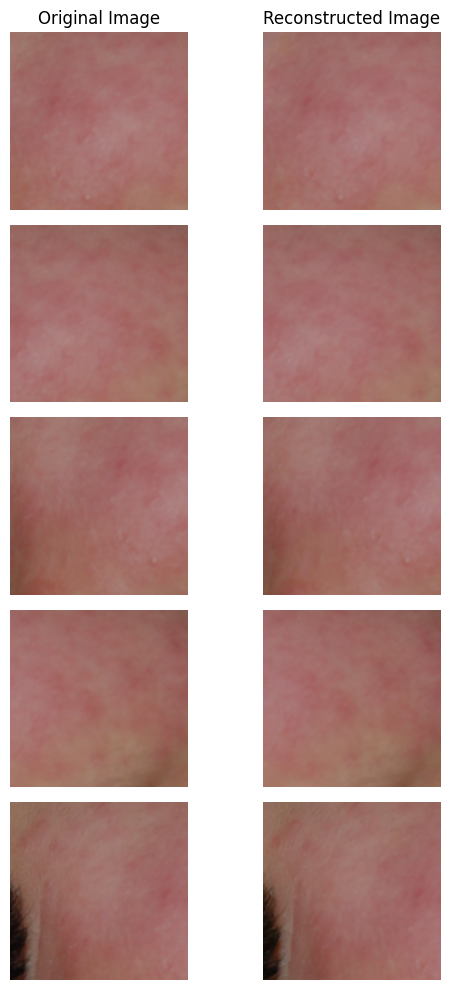

In [16]:
# Visual evaluation of reconstruction results, side by side
n_images = 5
dl = DataLoader(pair_dataset, batch_size=n_images,collate_fn=pair_collate_fn)

for batch in dl:
    data= batch["img"]
    data = data.to(device)

    # Reconstruct
    with torch.no_grad():
        reconstructed = vae(data, return_dict=False)[0]

  # Create a figure and subplots with a 5x2 grid
    fig, axes = plt.subplots(n_images, 2, figsize=(6, 10))

    for i in range(reconstructed.shape[0]):
        # Set title
        if i == 0:
            axes[i,0].set_title("Original Image")
            axes[i,1].set_title("Reconstructed Image")
        # Original            
        axes[i,0].imshow(np.moveaxis(data[i,...].cpu().numpy(),0,-1))
        axes[i,0].axis('off')
        # Reconstructed
        axes[i,1].imshow(np.moveaxis(reconstructed[i].cpu().numpy(),0,-1))
        axes[i,1].axis('off')
    plt.tight_layout()
    plt.show()
    break

The visual results look quite good, however it's always a better idea to evaluate them with some metrics.  
Two metrics will be used:
- PSNR(Peak signal to noise ratio): just a rescaling of the MSE, the higher it is the better
- SSIM(Structural similarity index measure): more focused on evaluating the structure of two images rather than local variations
- FID

In [9]:
# Create the metrics
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)

fid = FrechetInceptionDistance(normalize=True).to(device)
psnrs = []
ssims = []

dl = DataLoader(pair_dataset, batch_size=32,collate_fn=pair_collate_fn)

for idx, batch in enumerate(dl):
    data= batch["img"]
    data = data.to(device)

    # Reconstruct
    with torch.no_grad():
        reconstructed = vae(data, return_dict=False)[0]

    # Compute metrics
    fid.update(data, real=True)
    fid.update(reconstructed, real=False)

    psnrs.append(psnr(reconstructed, data).item())
    ssims.append(ssim(reconstructed, data).item())

print("Avg PSNR:", np.mean(psnrs))
print("Avg SSIM", np.mean(ssims))
out_fid = float(fid.compute())
print("FID:", out_fid)


Avg PSNR: 34.3703924385277
Avg SSIM 0.7943100813809816
FID: 14.523656845092773


It turns out that the stock autoencoder from stable diffusion works well enough, so we will keep using it.

# Unconditional Latent Diffusion Model
The core component of a LDM is what I call the denoiser. A network tasked with predicting the reverse diffusion process.  
The input to this model will be an image at a certain noise level and the output is supposed to be a slightly less noisy image (in reality the noise added to an unnoised image to get the image at the current noise levels, but these two outputs can be considered equivalent).  

Since this is still an Img2Img task we will use a tried and tested UNet (UNet2DModel), the only peculiarity of this UNet is the intermission of self attention blocks between convolutional blocks.    
These blocks do not matter too much when we use an unconditional model but they are crucial if we were to provide additional conditioning to the network (through text for example).

In [20]:
from diffusion_models import UnconditionalPipeline

class DERMDiff(pl.LightningModule):
    def __init__(self,  autoencoder: AutoencoderKL, unet_out_channels:List[str]=None, unet_attn:List[bool]=None, learning_rate:float = 1e-5, 
                train_scheduler = None,sample_size = (256,256)):
        super().__init__()
        if unet_out_channels is None:
            unet_out_channels = [128,128,256,512]
        if unet_attn is None:
            unet_attn = [False, False, True, True]
        
        assert len(unet_attn) == len(unet_out_channels)

        self.learning_rate = learning_rate

        # Instantiate the Unet denoiser
        unet_down_blocks = ["DownBlock2D" if attn else "AttnDownBlock2D" for attn in unet_attn]
        unet_up_blocks = ["UpBlock2D" if attn else "AttnUpBlock2D" for attn in unet_attn[::1]]# Reversed attention map
        self.denoiser = UNet2DModel(down_block_types= unet_down_blocks, up_block_types=unet_up_blocks, 
                                    block_out_channels=unet_out_channels,
                                    in_channels=4,out_channels=4)
        self.denoiser.config.sample_size = 32

        if train_scheduler is None:
            self.scheduler = diffusers.DDPMScheduler(num_train_timesteps=1000)
        else:
            self.scheduler = train_scheduler

        self.autoencoder = autoencoder
        # Freeze AE
        if self.autoencoder is not None:
            self.autoencoder.requires_grad_(False)

        self.sample_size = sample_size

        self.automatic_optimization = True
    
    def training_step(self, batch, batch_idx):
        images = batch["img"]
        masks = batch["mask"]

        # Convert images to latent space
        with torch.no_grad():
            latents = self.autoencoder.encode(images).latent_dist.sample()
            latents = latents * self.autoencoder.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, self.scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

            # Forward diffusion
            noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

        # Predict the noise residual and compute loss
        noise_pred = self.denoiser(noisy_latents, timesteps).sample
        loss = F.mse_loss(noise_pred, noise, reduction="mean")

        self.log_dict({'train/loss': loss.item()}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch["img"]
        masks = batch["mask"]

        # Convert images to latent space (shall we cache this?)
        with torch.no_grad():
            latents = self.autoencoder.encode(images).latent_dist.sample()
            latents = latents * self.autoencoder.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, self.scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

            # Forward diffusion
            noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

            # Predict the noise residual and compute loss
            noise_pred = self.denoiser(noisy_latents, timesteps).sample
            loss = F.mse_loss(noise_pred, noise, reduction="mean")

        self.log_dict({'val/loss': loss.item()}, prog_bar=True)
        return loss

    def on_train_epoch_end(self) -> None:
        # Define pipeline
        pipeline = self.get_pipeline()
        n_samples, steps = 8, 50
        pipeline.to(self.device)

        os.makedirs(f"outputs-diff/epoch-{self.current_epoch}/", exist_ok=True)
        images = pipeline(batch_size=n_samples, height=self.sample_size[1], width=self.sample_size[0], num_inference_steps=steps).images
        for idx, im in enumerate(images):
            im.save(f"outputs-diff/epoch-{self.current_epoch}/{idx:06}.png")

    def get_pipeline(self, scheduler = None):
        pipeline = UnconditionalPipeline(
            vae=self.autoencoder,
            unet=self.denoiser,
            scheduler=self.scheduler if scheduler is None else scheduler,
            text_encoder=None,
            tokenizer=None,
            safety_checker=None,
            feature_extractor=None

        )
        return pipeline

    def configure_optimizers(self):
        beta_1, beta_2 = 0.9, 0.999
        weight_decay = 1e-2
        epsilon = 1e-08

        opt = torch.optim.AdamW(self.denoiser.parameters(),
                                lr=self.learning_rate, betas=(beta_1, beta_2),
                                weight_decay=weight_decay, eps=epsilon)

        return [opt], []


## Training

In [9]:

seed_everything(42)
torch.set_float32_matmul_precision('medium')

train_ds, val_ds = torch.utils.data.random_split(pair_dataset, [0.95,0.05])
val_ds = train_ds

batch_size = 32 # As big as you need

train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=0, collate_fn=pair_collate_fn)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=0, collate_fn=pair_collate_fn)

# Define training hyperparameters
epochs = 50
lr = 1e-4
print(f"Epochs:{epochs}")
print(f"Total training steps: {epochs* len(train_ds)//batch_size}")

# Instantiating the pl module, trainer and maybe callbacks
model = DERMDiff(learning_rate=lr, autoencoder=vae)

trainer = pl.Trainer(devices=[1], max_epochs=epochs, fast_dev_run=False, limit_val_batches=0)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

# Save the model weights
# In this way both the trained as well as the untrained parts of the pipeline are saved, but that's fine
model.get_pipeline().save_pretrained("DermDiff")

Global seed set to 42


Epochs:50
Total training steps: 10515


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\lightning\pytorch\trainer\call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:128: FutureWarning: The configuration file of this scheduler: DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.16.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "thresholding": false,
  "trained_betas": null,
  

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:27                                                                                   │
│                                                                                                  │
│   24                                                                                             │
│   25 # Save the model weights                                                                    │
│   26 # In this way both the trained as well as the untrained parts of the pipeline are saved,    │
│ ❱ 27 model.get_pipeline().save_pretrained("DermDiff")                                            │
│   28                                                                                             │
│                                                                                                  │
│ c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\diffusers\pipelines\pipeli │
│ ne_utils.py:607 in save_pretrained                                                               │
│                                                                                                  │
│    604 │   │   │   if save_method_accept_variant:                                                │
│    605 │   │   │   │   save_kwargs["variant"] = variant                                          │
│    606 │   │   │                                                                                 │
│ ❱  607 │   │   │   save_method(os.path.join(save_directory, pipeline_component_name), **save_kw  │
│    608 │   │                                                                                     │
│    609 │   │   # finally save the config                                                         │
│    610 │   │   self.save_config(save_directory)                                                  │
│                                                                                                  │
│ c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\diffusers\models\modeling_ │
│ utils.py:323 in save_pretrained                                                                  │
│                                                                                                  │
│   320 │   │   │   │   state_dict, os.path.join(save_directory, weights_name), metadata={"forma   │
│   321 │   │   │   )                                                                              │
│   322 │   │   else:                                                                              │
│ ❱ 323 │   │   │   torch.save(state_dict, os.path.join(save_directory, weights_name))             │
│   324 │   │                                                                                      │
│   325 │   │   logger.info(f"Model weights saved in {os.path.join(save_directory, weights_name)   │
│   326                                                                                            │
│                                                                                                  │
│ c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\torch\serialization.py:423 │
│ in save                                                                                          │
│                                                                                                  │
│    420 │                                                                                         │
│    421 │   if _use_new_zipfile_serialization:                                                    │
│    422 │   │   with _open_zipfile_writer(f) as opened_zipfile:                                   │
│ ❱  423 │   │   │   _save(obj, opened_zipfile, pickle_module, pickle_protocol)                    │
│    424 │   │   │   return                                                                        │
│    425 │   else:                                           

# Testing the LDM

You have disabled the safety checker for <class 'diffusion_models.UnconditionalPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


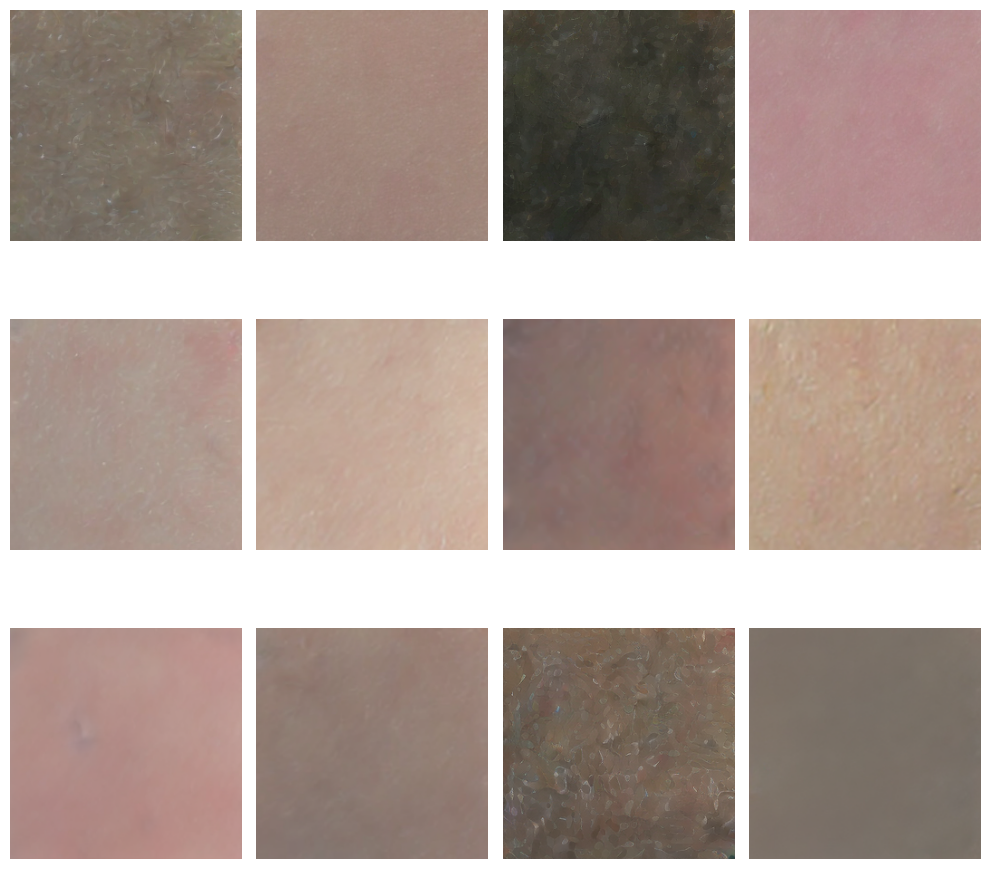

In [26]:
# Load model (could also load pipeline directly but whatever)
vae = AutoencoderKL.from_pretrained("DermDiff/vae", local_files_only=True)
unet = UNet2DModelC.from_pretrained("DermDiff/unet", local_files_only=True)
model = DERMDiff(autoencoder=vae, learning_rate=0)
unet.config.sample_size=32
model.denoiser = unet
# Example outputs
# Use a better inference scheduler than DDPM. Surprisingly enough the scheduler is very important here
from diffusers.schedulers import UniPCMultistepScheduler, EulerAncestralDiscreteScheduler, DDIMScheduler
eulera = EulerAncestralDiscreteScheduler()
unipc = UniPCMultistepScheduler()
ddim = DDIMScheduler()
pipeline = model.get_pipeline(scheduler=unipc).to("cuda")

generated_images = pipeline(batch_size=12, height=256, width=256, num_inference_steps=100, generator=torch.Generator().manual_seed(30)).images

rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
for i in range(rows):
    for j in range(cols):
        axs[i, j].imshow(generated_images[i*cols+j])
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


A very curious thing is how the scheduler (which in essence defines how the stochastic differential equation describing the reverse diffusion process is solved) choice is very relevant, even with a fairly high number of steps. 
This is usually not the case with diffusion models.

### FID Evaluation

In [27]:
# Instantatiate FID object

from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(normalize=True).to(device)
# Generate fake images
bs = 32
n_samples = 8000
for i in range(n_samples//bs):
    images = pipeline(batch_size=bs, height=256, width=256, num_inference_steps=100, output_type="np").images
    images = torch.as_tensor(np.moveaxis(images, -1,1)).to(device)
    fid.update(images, real=False)

# Add true images to FID computation
gt_dl = DataLoader(dataset=pair_dataset, batch_size=bs, shuffle=False, collate_fn=pair_collate_fn,
                    num_workers=0, pin_memory=True)
for batch in gt_dl:
    fid.update(batch["img"].to(device), real=True)
print(f"FID:{fid.compute()}")

100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


FID:120.69799041748047


We got visual results which are much better than the GAN, and the FID evaluation corroborates this. 
Overall the results are still not the best, but at least sometimes the network knows how to create a realistic-looking image.

# Using Masks as control
We are able to sometimes generate sensible images with our unconditional diffusion model, however we can't control the final result.  
We could have created a Conditional Diffusion Model which takes in input the colored mask as well, but this approach is not so flexible.  

A popular approach is one called ControlNet, this works by training a copy of the model with most of the weights frozen and with some added layers.
The activations of this model are then added to the activations of the standard denoiser (in a certain point of the unet) to guide it towards our control.

In [28]:
class DERMControlNet(pl.LightningModule):
    def __init__(self, autoencoder: AutoencoderKL = None, unet: UNet2DModel = None, train_scheduler = None,
                 learning_rate:float = 1e-5, sample_size=(256, 256)):
        super().__init__()
        self.learning_rate = learning_rate

        self.controlnet = CControlNetModel.from_unet(unet)

        if train_scheduler is None:
            self.scheduler = diffusers.DDPMScheduler(num_train_timesteps=1000)
        else:
            self.scheduler = train_scheduler

        # Freeze AE, Denoiser
        self.autoencoder = autoencoder
        if self.autoencoder is not None:
            self.autoencoder.requires_grad_(False)

        self.denoiser = unet
        if self.denoiser is not None:
            self.denoiser.requires_grad_(False)

        self.sample_size = sample_size


    def training_step(self, batch, batch_idx):
        img_inputs = batch['img']
        cnet_inputs = batch['mask']

        # Convert images to latent space
        with torch.no_grad():
            latents = self.autoencoder.encode(img_inputs).latent_dist.sample()
            latents = latents * self.autoencoder.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, self.scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

            # Forward diffusion
            noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

        # Get the activations of the controlnet model
        down_block_res_samples, mid_block_res_sample = self.controlnet(
            noisy_latents,
            timesteps,
            controlnet_cond=cnet_inputs,
            return_dict=False,
        )

        # Predict the noise residual and compute loss, using cnet activations
        noise_pred = self.denoiser(noisy_latents, timesteps, 
                                    down_block_additional_residuals=down_block_res_samples,
                                    mid_block_additional_residual=mid_block_res_sample).sample
        loss = F.mse_loss(noise_pred, noise, reduction="mean")

        self.log_dict({'train/loss': loss.item()})
        return loss

    def validation_step(self, batch, batch_idx):
        img_inputs = batch['img']
        cnet_inputs = batch['mask']

        # Convert images to latent space
        with torch.no_grad():
            latents = self.autoencoder.encode(img_inputs).latent_dist.sample()
            latents = latents * self.autoencoder.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, self.scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

            # Forward diffusion
            noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

            # Get the activations of the controlnet model
            down_block_res_samples, mid_block_res_sample = self.controlnet(
                noisy_latents,
                timesteps,
                controlnet_cond=cnet_inputs,
                return_dict=False,
            )

            # Predict the noise residual and compute loss, using cnet activations
            noise_pred = self.denoiser(noisy_latents, timesteps, 
                                        down_block_additional_residuals=down_block_res_samples,
                                        mid_block_additional_residual=mid_block_res_sample).sample
            loss = F.mse_loss(noise_pred, noise, reduction="mean")

        self.log_dict({'val/loss': loss.item()})
        return loss

    def on_train_epoch_end(self) -> None:
        # Define pipeline
        # Take a sample image and controll
        pipeline = self.get_pipeline()
        control_image = Image.open("D:/test.png").convert("RGB")
        image_tensor = torch.unsqueeze(torch.as_tensor(np.moveaxis(np.array(control_image) / 255,-1,0)),0)
        with torch.no_grad():
            images = pipeline(batch_size=1, image=image_tensor, height=256, width=256, num_inference_steps=50).images

        os.makedirs("cnet_test", exist_ok=True)
        os.makedirs(f"cnet_test/epoch={self.current_epoch}", exist_ok=True)
        for idx, im in enumerate(images):
            im.save(f"cnet_test/epoch={self.current_epoch}/{idx:03}.png")

    def get_pipeline(self, scheduler = None):
        # StableDiffusionControlNetPipeline is SD, takes conditioning, hopefully turning it into unconditional is not too annoying
        pipeline = UnconditionalControlNetPipeline(
            vae= self.autoencoder, unet=self.denoiser, text_encoder=None, tokenizer=None, scheduler = scheduler if scheduler is not None else self.scheduler,
            controlnet=self.controlnet, safety_checker=None, feature_extractor=None, requires_safety_checker=False
        )
        return pipeline

    def configure_optimizers(self):
        beta_1, beta_2 = 0.9, 0.999
        weight_decay = 1e-2
        epsilon = 1e-08

        opt = torch.optim.AdamW(self.controlnet.parameters(),
                                lr=self.learning_rate, betas=(beta_1, beta_2),
                                weight_decay=weight_decay, eps=epsilon)

        return [opt], []



## Training the ControlNet

In [10]:
seed_everything(42)
torch.set_float32_matmul_precision('medium')

train_ds, val_ds = torch.utils.data.random_split(pair_dataset, [0.99,0.01])
val_ds = train_ds

batch_size = 32 # As big as you need

train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=0, collate_fn=pair_collate_fn)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=0, collate_fn=pair_collate_fn)

# Define training hyperparameters
epochs = 50
lr = 1e-4
print(f"Epochs:{epochs}")
print(f"Total training steps: {epochs* len(train_ds)//batch_size}")

# Instantiating the pl module, trainer
vae = AutoencoderKL.from_pretrained("DermDiff/vae/")
unet = UNet2DModelC.from_pretrained("DermDiff/unet/")

cnet_model = DERMControlNet(autoencoder=vae, unet=unet, learning_rate=lr)
trainer = pl.Trainer(devices=[1], max_epochs=epochs, fast_dev_run=False, limit_val_batches=0)

trainer.fit(cnet_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

# Save everything
cnet_model.get_pipeline().save_pretrained("DERMControlNet")

Global seed set to 42


Epochs:50
Total training steps: 10959


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type             | Params
-------------------------------------------------
0 | controlnet  | CControlNetModel | 20.9 M
1 | autoencoder | AutoencoderKL    | 83.7 M
2 | denoiser    | UNet2DModelC     | 64.4 M
-------------------------------------------------
20.9 M    Trainable params
148 M     Non-trainable params
169 M     Total params
676.078   Total estimated model params size (MB)
c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performa

Epoch 0:   0%|          | 0/220 [00:00<?, ?it/s] 

C:\Users\BIAGINI\AppData\Local\Temp\ipykernel_34136\1013481603.py:404: FutureWarning: Accessing config attribute `scaling_factor` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'scaling_factor' over 'AutoencoderKL's config object instead, e.g. 'unet.config.scaling_factor'.
  latents = latents * self.autoencoder.scaling_factor
c:\Users\BIAGINI\PycharmProjects\qps.diffusion\venv\lib\site-packages\diffusers\configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0: 100%|██████████| 220/220 [05:33<00:00,  1.52s/it, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.38it/s]


Epoch 1: 100%|██████████| 220/220 [02:40<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


Epoch 2: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.44it/s]


Epoch 3: 100%|██████████| 220/220 [02:38<00:00,  1.39it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.93it/s]


Epoch 4: 100%|██████████| 220/220 [02:41<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.16it/s]


Epoch 5: 100%|██████████| 220/220 [02:44<00:00,  1.34it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.81it/s]


Epoch 6: 100%|██████████| 220/220 [02:43<00:00,  1.35it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.21it/s]


Epoch 7: 100%|██████████| 220/220 [02:43<00:00,  1.35it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.56it/s]


Epoch 8: 100%|██████████| 220/220 [02:43<00:00,  1.35it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.82it/s]


Epoch 9: 100%|██████████| 220/220 [02:42<00:00,  1.35it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


Epoch 10: 100%|██████████| 220/220 [02:43<00:00,  1.35it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.66it/s]


Epoch 11: 100%|██████████| 220/220 [02:40<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.03it/s]


Epoch 12: 100%|██████████| 220/220 [02:41<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.47it/s]


Epoch 13: 100%|██████████| 220/220 [02:42<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.52it/s]


Epoch 14: 100%|██████████| 220/220 [02:38<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 12.80it/s]


Epoch 15: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


Epoch 16: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.61it/s]


Epoch 17: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


Epoch 18: 100%|██████████| 220/220 [02:38<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.32it/s]


Epoch 19: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.98it/s]


Epoch 20: 100%|██████████| 220/220 [02:38<00:00,  1.39it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.69it/s]


Epoch 21: 100%|██████████| 220/220 [02:38<00:00,  1.39it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


Epoch 22: 100%|██████████| 220/220 [02:42<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.46it/s]


Epoch 23: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


Epoch 24: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


Epoch 25: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.58it/s]


Epoch 26: 100%|██████████| 220/220 [02:40<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.56it/s]


Epoch 27: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


Epoch 28: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


Epoch 29: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.44it/s]


Epoch 30: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.50it/s]


Epoch 31: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


Epoch 32: 100%|██████████| 220/220 [02:38<00:00,  1.39it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.04it/s]


Epoch 33: 100%|██████████| 220/220 [02:40<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.69it/s]


Epoch 34: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.45it/s]


Epoch 35: 100%|██████████| 220/220 [02:40<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.42it/s]


Epoch 36: 100%|██████████| 220/220 [02:40<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.40it/s]


Epoch 37: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


Epoch 38: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.17it/s]


Epoch 39: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.96it/s]


Epoch 40: 100%|██████████| 220/220 [02:40<00:00,  1.37it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


Epoch 41: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.84it/s]


Epoch 42: 100%|██████████| 220/220 [02:38<00:00,  1.39it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.39it/s]


Epoch 43: 100%|██████████| 220/220 [02:38<00:00,  1.39it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


Epoch 44: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.88it/s]


Epoch 45: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.73it/s]


Epoch 46: 100%|██████████| 220/220 [02:39<00:00,  1.38it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 14.67it/s]


Epoch 47: 100%|██████████| 220/220 [02:41<00:00,  1.36it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.82it/s]


Epoch 48: 100%|██████████| 220/220 [02:43<00:00,  1.34it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.77it/s]


Epoch 49: 100%|██████████| 220/220 [02:42<00:00,  1.35it/s, v_num=78]

100%|██████████| 50/50 [00:03<00:00, 13.75it/s]
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 220/220 [03:24<00:00,  1.08it/s, v_num=78]


## Evaluation

Let's start by exploring whether our Unconditional LDM + ControlNet is able to follow the control

100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


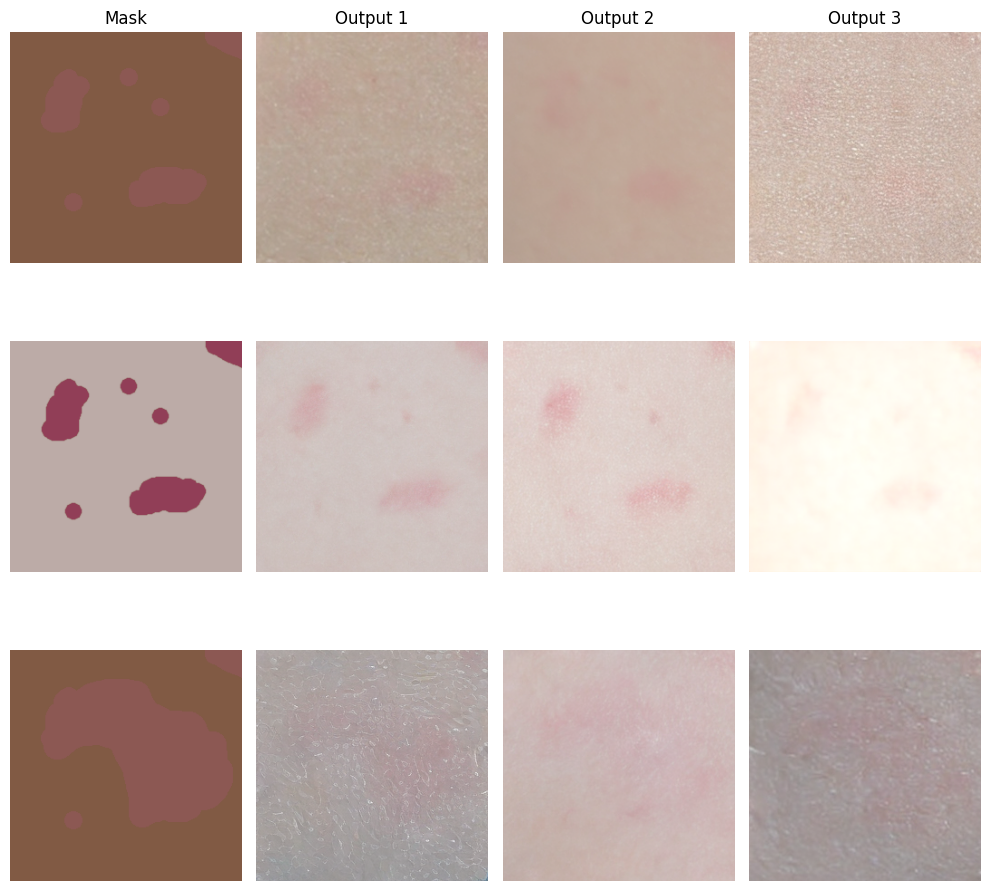

In [32]:
vae = AutoencoderKL.from_pretrained("D:/DERMControlNet/vae")
unet = UNet2DModelC.from_pretrained("D:/DERMControlNet/unet")
cnet = CControlNetModel.from_unet(unet)
cnet_state_dict = torch.load("D:/DERMControlNet/controlnet/diffusion_pytorch_model.bin", map_location="cuda")
cnet.load_state_dict(cnet_state_dict)

cnet_model = DERMControlNet(autoencoder=vae, unet=unet, learning_rate=0)
cnet_model.controlnet = cnet

cnet_pipeline = cnet_model.get_pipeline(scheduler=UniPCMultistepScheduler()).to("cuda")

test_masks = ["D:/test_images/mask1.png", "D:/test_images/mask2.png", "D:/test_images/mask3.png"]

bs = 3
fig, axes = plt.subplots(len(test_masks), 1+bs, figsize=(10, 10))

for i,mask_path in enumerate(test_masks):
    if i == 0:
        axes[i,0].set_title("Mask")
        for j in range(1,bs+1):
            axes[i,j].set_title(f"Output {j}")
        
    mask = Image.open(mask_path).convert("RGB")

    image_tensor = torch.unsqueeze(torch.as_tensor(np.moveaxis(np.array(mask) / 255,-1,0)),0)
    with torch.no_grad():
        images = cnet_pipeline(batch_size=bs, image=image_tensor, height=256, width=256, num_inference_steps=100).images
    axes[i,0].imshow(mask)
    axes[i,0].axis('off')
    for j in range(1,bs+1):
        axes[i,j].imshow(images[j-1])
        axes[i,j].axis('off')
        
plt.tight_layout()
plt.show()



We obtained very reasonable results, the locations of skin that are supposed to be diseased are treated correctly and the color of the skin is close to the color provided in the colored mask.

Let's also evaluate the FID:

In [42]:
# Instantatiate FID object

device = 'cuda'
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(normalize=True).to(device)
bs = 64
dl = DataLoader(pair_dataset, batch_size=bs, num_workers=0, collate_fn=pair_collate_fn)

for batch in dl:
    image_tensor = batch["mask"]
    with torch.no_grad():
        images = cnet_pipeline(batch_size=image_tensor.shape[0], image=image_tensor, 
                               height=256, width=256, num_inference_steps=100, output_type="np").images     
        images = torch.as_tensor(np.moveaxis(images, -1,1)).to(device)
    fid.update(images, real=False)
    fid.update(batch["img"].to(device), real=True)
print(f"FID:{fid.compute()}")

100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


FID:74.11418151855469


# Conclusions

Latent diffusion models turned out to be a much more effective models than a Pix2Pix GAN.  
The unconditional generation suffers from quite a few problems, like images that are either dark, bright or blurry; but when adding a control condition through the ControlNet network with a reasonable input control, such effects are greatly reduced.  
Furthermore a very reliable control was able to be achieved through this method, with a faithful adherence to position information of the diseased skin.